In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from sklearn import linear_model, cross_validation
from sklearn import grid_search
import pylab as plt
import numpy as np
from scipy.stats import linregress
pd.set_option("precision", 2)
execfile("../toolbox.py")

## Importing the data

In [108]:
growth_data = pd.read_csv("../data_source/all_data.csv", index_col=['code', 'year'], 
                   usecols=["GDP_PC_PWT"] + ['code', 'year'])
growth_data['growth'] = growth(growth_data, "GDP_PC_PWT", how='past', as_rate=True)
data = pd.read_stata("sdn1402/SDN_spells_dataset.dta", columns=['gini_net', "WBcode", "year", 'gini_market',
 'red_abs_diff', 'red_abs_diff_solt_sample', 'redist_baseline', 'lmfdebtl', 'p4polity2',
 'du3_l1usrategr', 'db3_l1tttgr', 'acc_stop_10', 'length_10', 'type_10', 'income_pc_10_0',
 'acc_startpl4_10', 'spell_ids_10', 'lnpopgr', 'lni', 'ltoted', 'int_redist_baseline_t25',
 'int_redist_baseline_b75', 'int_red_abs_diff_solt_sample_t25', 'int_red_abs_diff_solt_sample_b75',
 'int_red_abs_diff_t25', 'int_red_abs_diff_b75', 'pop', 'open'])

data.set_index(["WBcode", "year"],  inplace=True)
data.index.names = ['code', 'year']
data['growth'] = growth_data['growth']
data['ln_GDP'] = growth_data['GDP_PC_PWT'].apply(np.log)
data['10y_growth'] = rolling_mean(growth_data, 'growth', 10, 5, how='futur',sum=True)

# five-years period data
fy_data = pd.read_stata("sdn1402/SDN_5year_average_dataset.dta", columns=['wbcode', 'year', 'gini_net',
 'gini_market', 'open', 'lmfdebtl', 'p4polity2', 'redist_baseline', 'red_abs_diff', 'red_abs_diff_solt_sample',
 'logincome_pc', 'diffyy_5', 'lny0_5', 'lnpopgr', 'lni', 'ltoted', 'oecd_1975', 'nonoecd_1975', 'db3_l1tttgr'])
fy_data.set_index(["wbcode", "year"],  inplace=True)
fy_data.index.names = ['code', 'year']
fy_data.loc[:, 'growth_rate'] = growth(fy_data, 'logincome_pc').apply(lambda x: 10**x - 1)

## Scatter plot

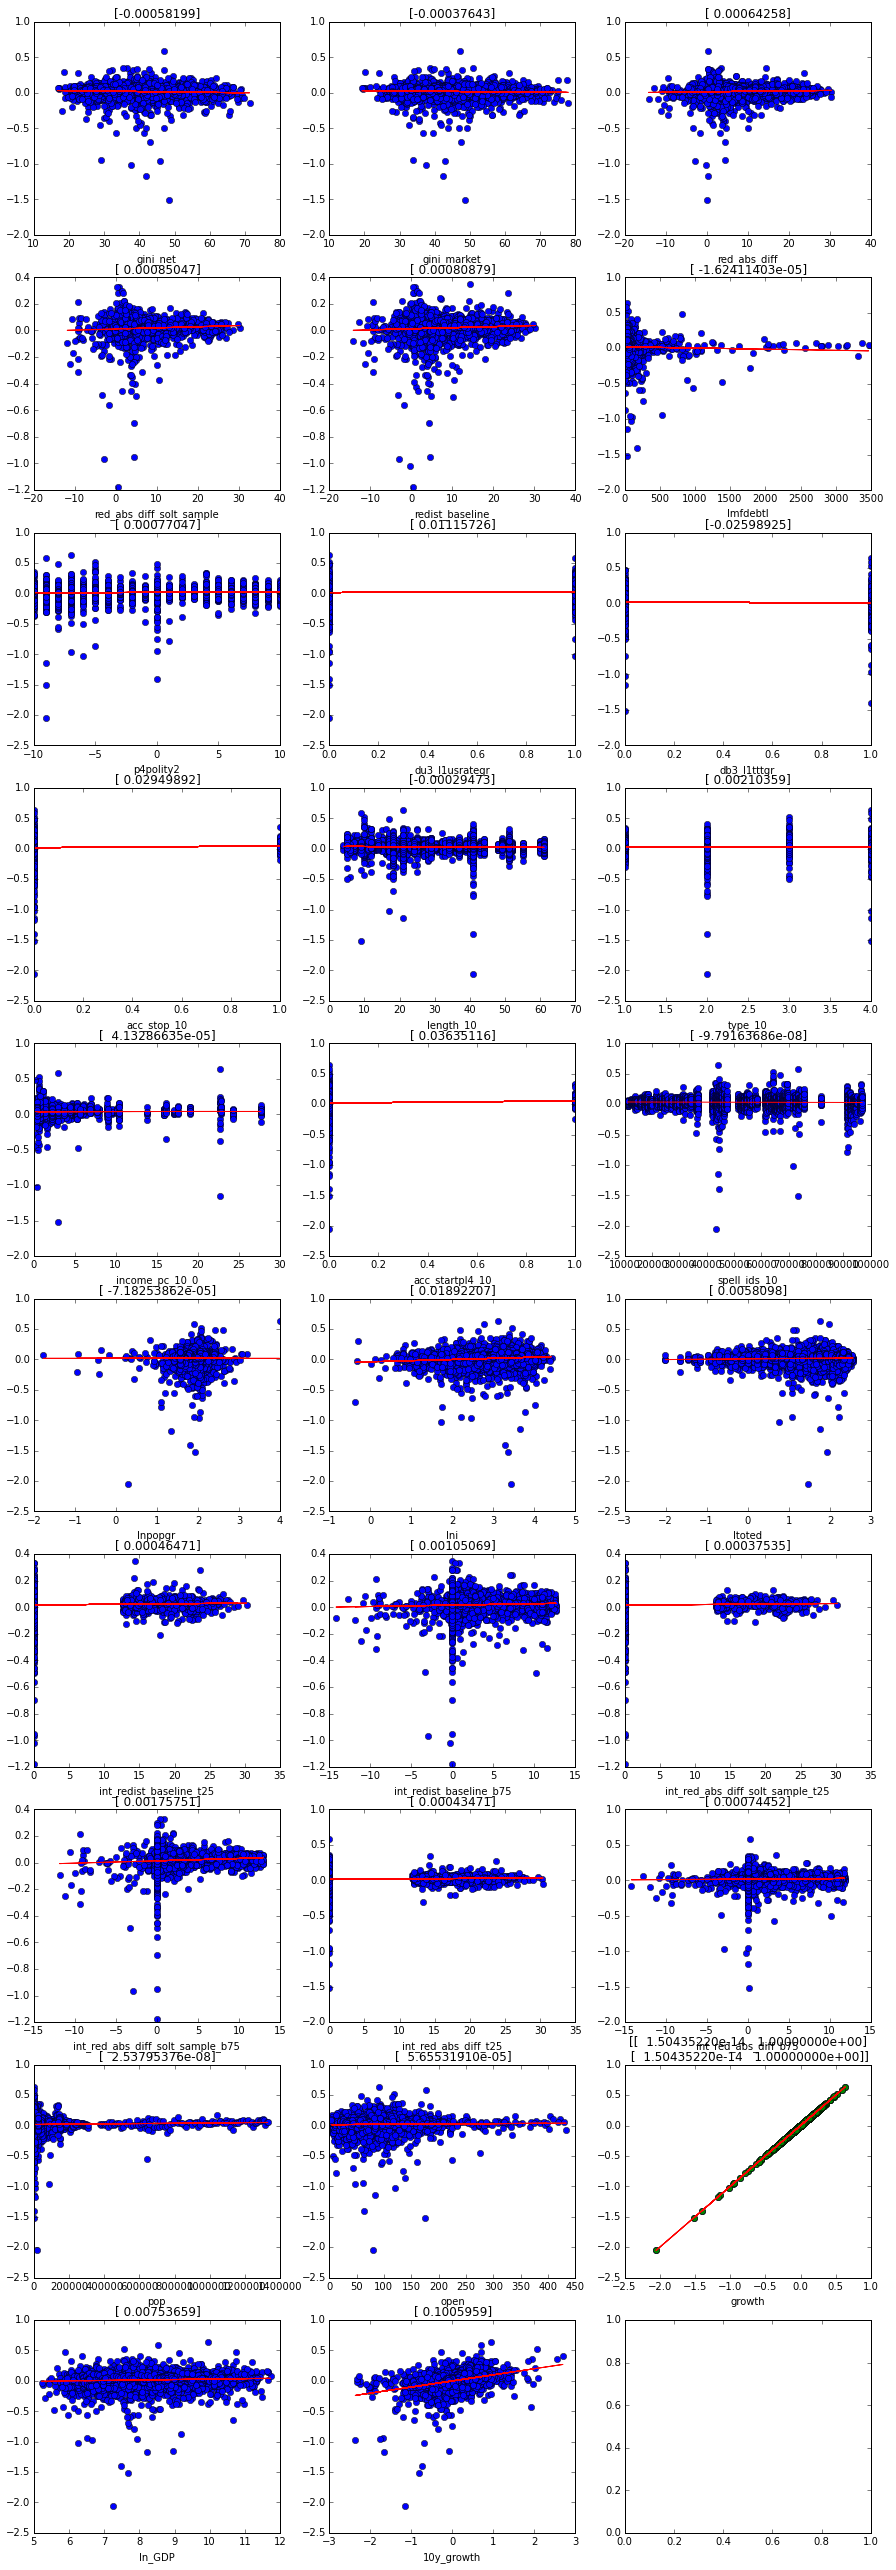

In [78]:
f, axarr = plt.subplots(10, 3, figsize=(15, 45))
for n, var in enumerate(data.keys()):
    i,j = n/3, n%3
    sel = data[[var, 'growth']].dropna(how='any')
    clf = linear_model.LinearRegression()
    clf.fit(sel[[var]], sel['growth'])
    axarr[i, j].plot(sel[var], sel['growth'], 'o')
    axarr[i, j].plot(sel[var], clf.predict(sel[[var]]), 'r')
    axarr[i, j].set_title(clf.coef_)
    axarr[i, j].set_xlabel(var)

# Simple correlations

## 10 years growth sum

Normalized coefficient :  [-0.05516963]
R**2 0.00304368833341


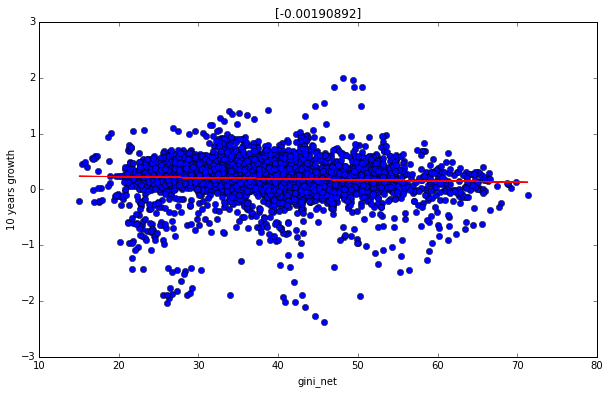

In [130]:
plt.figure(figsize=(10,6))
sel = data[['gini_net', '10y_growth']].dropna(how='any')
clf = linear_model.LinearRegression()
clf.fit(sel[['gini_net']], sel['10y_growth'])
plt.plot(sel['gini_net'], sel['10y_growth'], 'o')
plt.plot(sel['gini_net'], clf.predict(sel[['gini_net']]), 'r')
plt.title(clf.coef_)
plt.xlabel('gini_net')
plt.ylabel("10 years growth")

norm_sel = ((sel - sel.mean()) / sel.std())
clf = linear_model.LinearRegression()
clf.fit(norm_sel[['gini_net']], norm_sel['10y_growth'])
print "Normalized coefficient : ", clf.coef_
print "R**2", clf.score(norm_sel[['gini_net']], norm_sel['10y_growth'])

## Correlation on differences

Normalized coefficient :  [-0.05417403]
R**2 0.00293482509607


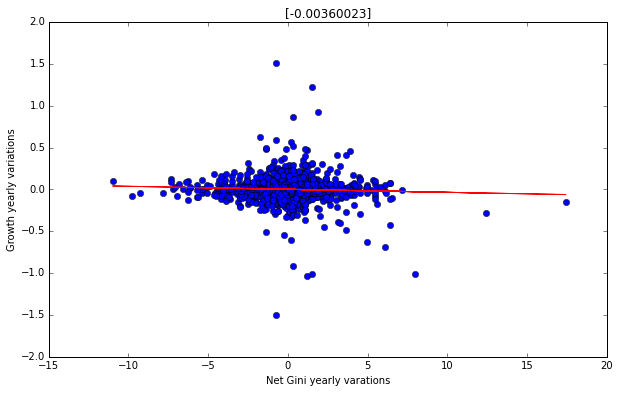

In [131]:
plt.figure(figsize=(10,6))
sel = data[['gini_net', 'growth']]
sel.loc[:, 'gini_net'] = growth(sel, 'gini_net')
sel.loc[:, 'growth'] = growth(sel, 'growth')
sel = sel.dropna()
clf = linear_model.LinearRegression()
clf.fit(sel[['gini_net']], sel['growth'])
plt.plot(sel['gini_net'], sel['growth'], 'o')
plt.plot(sel['gini_net'], clf.predict(sel[['gini_net']]), 'r')
plt.title(clf.coef_)
plt.xlabel('Net Gini yearly varations')
plt.ylabel("Growth yearly variations")

norm_sel = ((sel - sel.mean()) / sel.std())
clf = linear_model.LinearRegression()
clf.fit(norm_sel[['gini_net']], norm_sel['growth'])
print "Normalized coefficient : ", clf.coef_
print "R**2", clf.score(norm_sel[['gini_net']], norm_sel['growth'])

## Impact of long term variation of gini

Normalized coefficient :  [-0.1392453]
R**2 0.019389253967


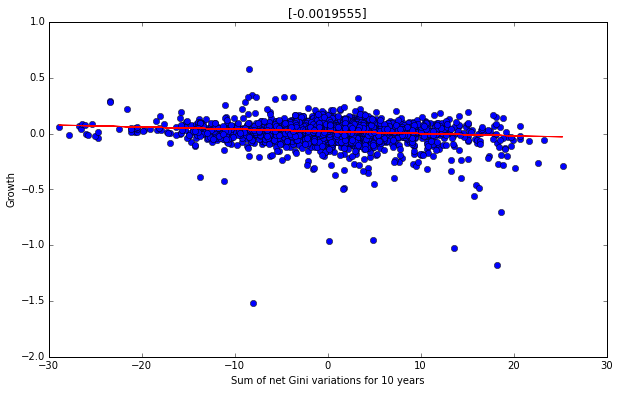

In [132]:
plt.figure(figsize=(10,6))
sel = data[['gini_net', 'growth']]
sel.loc[:, 'gini_net'] = growth(sel, 'gini_net')
sel.loc[:, 'gini_net'] = rolling_mean(sel, 'gini_net', 10, 5, how='past', sum=True)
sel = sel.dropna()
clf = linear_model.LinearRegression()
clf.fit(sel[['gini_net']], sel['growth'])
plt.plot(sel['gini_net'], sel['growth'], 'o')
plt.plot(sel['gini_net'], clf.predict(sel[['gini_net']]), 'r')
plt.title(clf.coef_)
plt.xlabel('Sum of net Gini variations for 10 years')
plt.ylabel("Growth")

norm_sel = ((sel - sel.mean()) / sel.std())
clf = linear_model.LinearRegression()
clf.fit(norm_sel[['gini_net']], norm_sel['growth'])
print "Normalized coefficient : ", clf.coef_
print "R**2", clf.score(norm_sel[['gini_net']], norm_sel['growth'])

## Impact of long term variation of gini on long term growth

Normalized coefficient :  [-0.04608403]
R**2 0.00212373762987


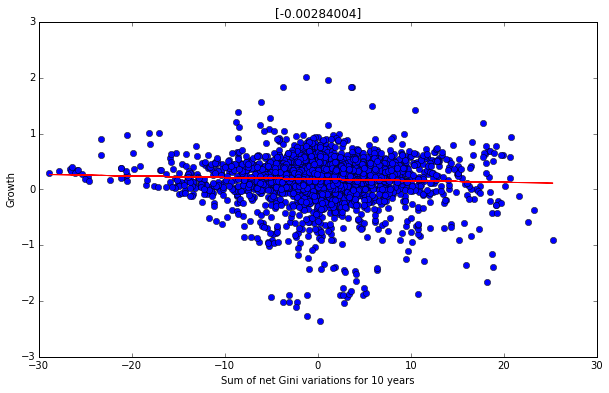

In [133]:
plt.figure(figsize=(10,6))
sel = data[['gini_net', 'growth']]
sel.loc[:, 'gini_net'] = growth(sel, 'gini_net')
sel.loc[:, 'gini_net'] = rolling_mean(sel, 'gini_net', 10, 5, how='past', sum=True)
sel.loc[:, 'growth'] = rolling_mean(sel, 'growth', 10, 5, how='futur', sum=True)
sel = sel.dropna()
clf = linear_model.LinearRegression()
clf.fit(sel[['gini_net']], sel['growth'])
plt.plot(sel['gini_net'], sel['growth'], 'o')
plt.plot(sel['gini_net'], clf.predict(sel[['gini_net']]), 'r')
plt.title(clf.coef_)
plt.xlabel('Sum of net Gini variations for 10 years')
plt.ylabel("Growth")

norm_sel = ((sel - sel.mean()) / sel.std())
clf = linear_model.LinearRegression()
clf.fit(norm_sel[['gini_net']], norm_sel['growth'])
print "Normalized coefficient : ", clf.coef_
print "R**2", clf.score(norm_sel[['gini_net']], norm_sel['growth'])

## Correlations on distance to country mean

Normalized coefficient :  [-0.04614653]
R**2 0.00212950196413


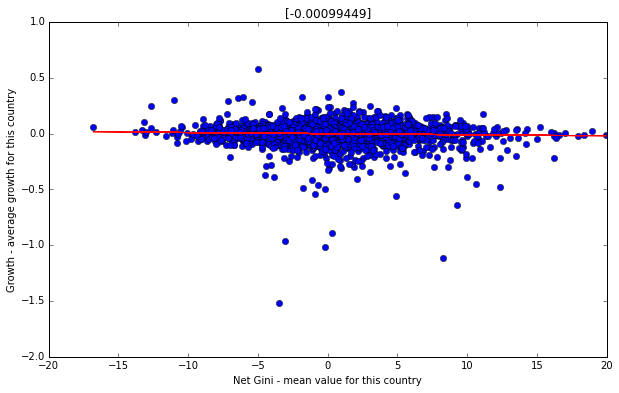

In [134]:
plt.figure(figsize=(10,6))
sel = data[['gini_net', 'growth']] - data.groupby(level=0).mean()[['gini_net', 'growth']]
sel = sel.dropna()
clf = linear_model.LinearRegression()
clf.fit(sel[['gini_net']], sel['growth'])
plt.plot(sel['gini_net'], sel['growth'], 'o')
plt.plot(sel['gini_net'], clf.predict(sel[['gini_net']]), 'r')
plt.title(clf.coef_)
plt.xlabel('Net Gini - mean value for this country')
plt.ylabel("Growth - average growth for this country")

norm_sel = ((sel - sel.mean()) / sel.std())
clf = linear_model.LinearRegression()
clf.fit(norm_sel[['gini_net']], norm_sel['growth'])
print "Normalized coefficient : ", clf.coef_
print "R**2", clf.score(norm_sel[['gini_net']], norm_sel['growth'])

## Impact of long term variation of gini on distances to mean

Normalized coefficient :  [-0.1255535]
R**2 0.015763681733


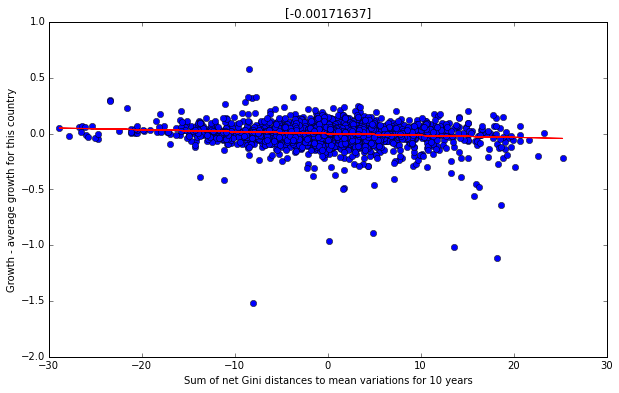

In [135]:
plt.figure(figsize=(10,6))
sel = data[['gini_net', 'growth']] - data.groupby(level=0).mean()[['gini_net', 'growth']]
sel.loc[:, 'gini_net'] = growth(sel, 'gini_net')
sel.loc[:, 'gini_net'] = rolling_mean(sel, 'gini_net', 10, 5, how='past', sum=True)
sel = sel.dropna()
clf = linear_model.LinearRegression()
clf.fit(sel[['gini_net']], sel['growth'])
plt.plot(sel['gini_net'], sel['growth'], 'o')
plt.plot(sel['gini_net'], clf.predict(sel[['gini_net']]), 'r')
plt.title(clf.coef_)
plt.xlabel('Sum of net Gini distances to mean variations for 10 years')
plt.ylabel("Growth - average growth for this country")

norm_sel = ((sel - sel.mean()) / sel.std())
clf = linear_model.LinearRegression()
clf.fit(norm_sel[['gini_net']], norm_sel['growth'])
print "Normalized coefficient : ", clf.coef_
print "R**2", clf.score(norm_sel[['gini_net']], norm_sel['growth'])

## 5 years data correlations

Normalized coefficient :  [-0.18840276]
R**2 0.0354955998726


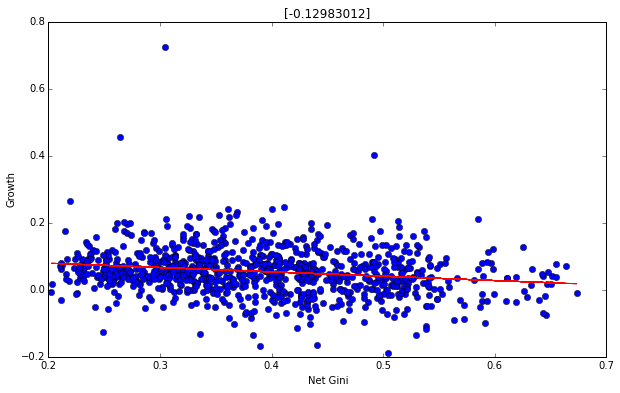

In [136]:
plt.figure(figsize=(10,6))
sel = fy_data[['gini_net', 'growth_rate']]
sel = sel.dropna()
clf = linear_model.LinearRegression()
clf.fit(sel[['gini_net']], sel['growth_rate'])
plt.plot(sel['gini_net'], sel['growth_rate'], 'o')
plt.plot(sel['gini_net'], clf.predict(sel[['gini_net']]), 'r')
plt.title(clf.coef_)
plt.xlabel('Net Gini')
plt.ylabel("Growth")

norm_sel = ((sel - sel.mean()) / sel.std())
clf = linear_model.LinearRegression()
clf.fit(norm_sel[['gini_net']], norm_sel['growth_rate'])
print "Normalized coefficient : ", clf.coef_
print "R**2", clf.score(norm_sel[['gini_net']], norm_sel['growth_rate'])

## 5 years data correlations on differences

Normalized coefficient :  [-0.02676982]
R**2 0.000716623328866


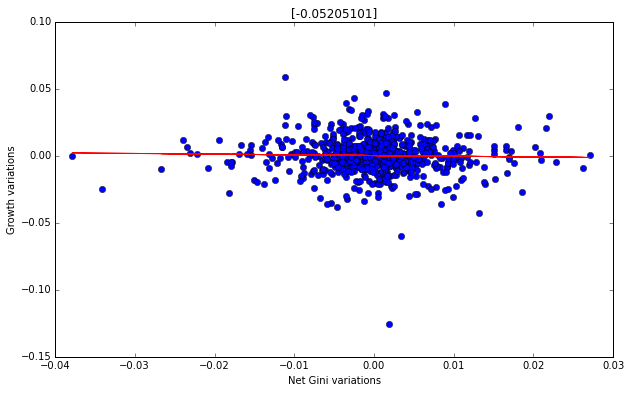

In [137]:
plt.figure(figsize=(10,6))
sel = fy_data[['gini_net', 'growth_rate']]
sel.loc[:, 'gini_net'] = growth(sel, "gini_net")
sel.loc[:, 'growth_rate'] = growth(sel, "growth_rate")
sel = sel.dropna()
clf = linear_model.LinearRegression()
clf.fit(sel[['gini_net']], sel['growth_rate'])
plt.plot(sel['gini_net'], sel['growth_rate'], 'o')
plt.plot(sel['gini_net'], clf.predict(sel[['gini_net']]), 'r')
plt.title(clf.coef_)
plt.xlabel('Net Gini variations')
plt.ylabel("Growth variations")

norm_sel = ((sel - sel.mean()) / sel.std())
clf = linear_model.LinearRegression()
clf.fit(norm_sel[['gini_net']], norm_sel['growth_rate'])
print "Normalized coefficient : ", clf.coef_
print "R**2", clf.score(norm_sel[['gini_net']], norm_sel['growth_rate'])

## 5 years data correlations Gini variations and futur growth variations

Normalized coefficient :  [ 0.00856403]
R**2 7.33426827264e-05


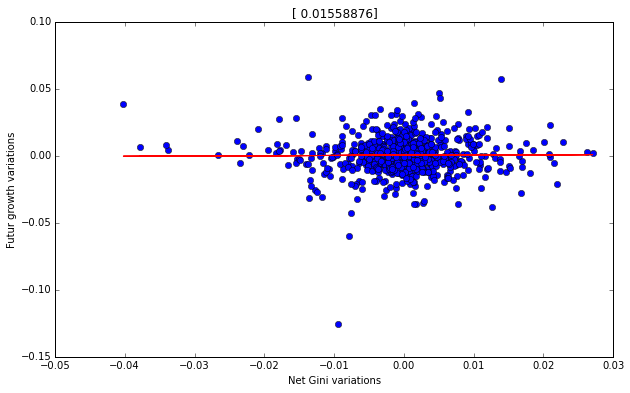

In [138]:
plt.figure(figsize=(10,6))
sel = fy_data[['gini_net', 'growth_rate']]
sel.loc[:, 'gini_net'] = growth(sel, "gini_net")
sel.loc[:, 'growth_rate'] = growth(sel, "growth_rate", how='futur')
sel = sel.dropna()
clf = linear_model.LinearRegression()
clf.fit(sel[['gini_net']], sel['growth_rate'])
plt.plot(sel['gini_net'], sel['growth_rate'], 'o')
plt.plot(sel['gini_net'], clf.predict(sel[['gini_net']]), 'r')
plt.title(clf.coef_)
plt.xlabel('Net Gini variations')
plt.ylabel("Futur growth variations")

norm_sel = ((sel - sel.mean()) / sel.std())
clf = linear_model.LinearRegression()
clf.fit(norm_sel[['gini_net']], norm_sel['growth_rate'])
print "Normalized coefficient : ", clf.coef_
print "R**2", clf.score(norm_sel[['gini_net']], norm_sel['growth_rate'])

## 5 years on Gini and futur growth variations

Normalized coefficient :  [ 0.03894153]
R**2 0.00151644280141


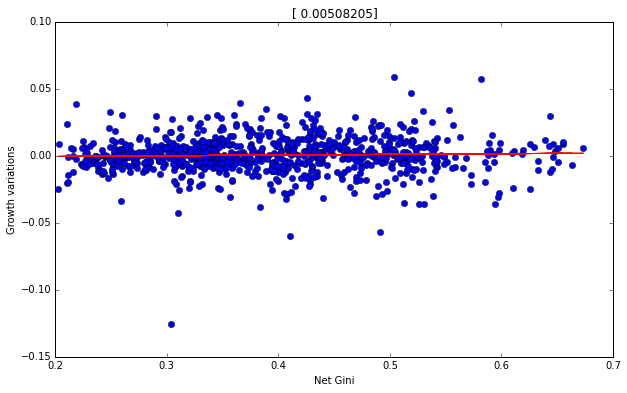

In [139]:
plt.figure(figsize=(10,6))
sel = fy_data[['gini_net', 'growth_rate']]
sel.loc[:, 'growth_rate'] = growth(sel, "growth_rate", how='futur')
sel = sel.dropna()
clf = linear_model.LinearRegression()
clf.fit(sel[['gini_net']], sel['growth_rate'])
plt.plot(sel['gini_net'], sel['growth_rate'], 'o')
plt.plot(sel['gini_net'], clf.predict(sel[['gini_net']]), 'r')
plt.title(clf.coef_)
plt.xlabel('Net Gini')
plt.ylabel("Growth variations")

norm_sel = ((sel - sel.mean()) / sel.std())
clf = linear_model.LinearRegression()
clf.fit(norm_sel[['gini_net']], norm_sel['growth_rate'])
print "Normalized coefficient : ", clf.coef_
print "R**2", clf.score(norm_sel[['gini_net']], norm_sel['growth_rate'])

## Scatter plot

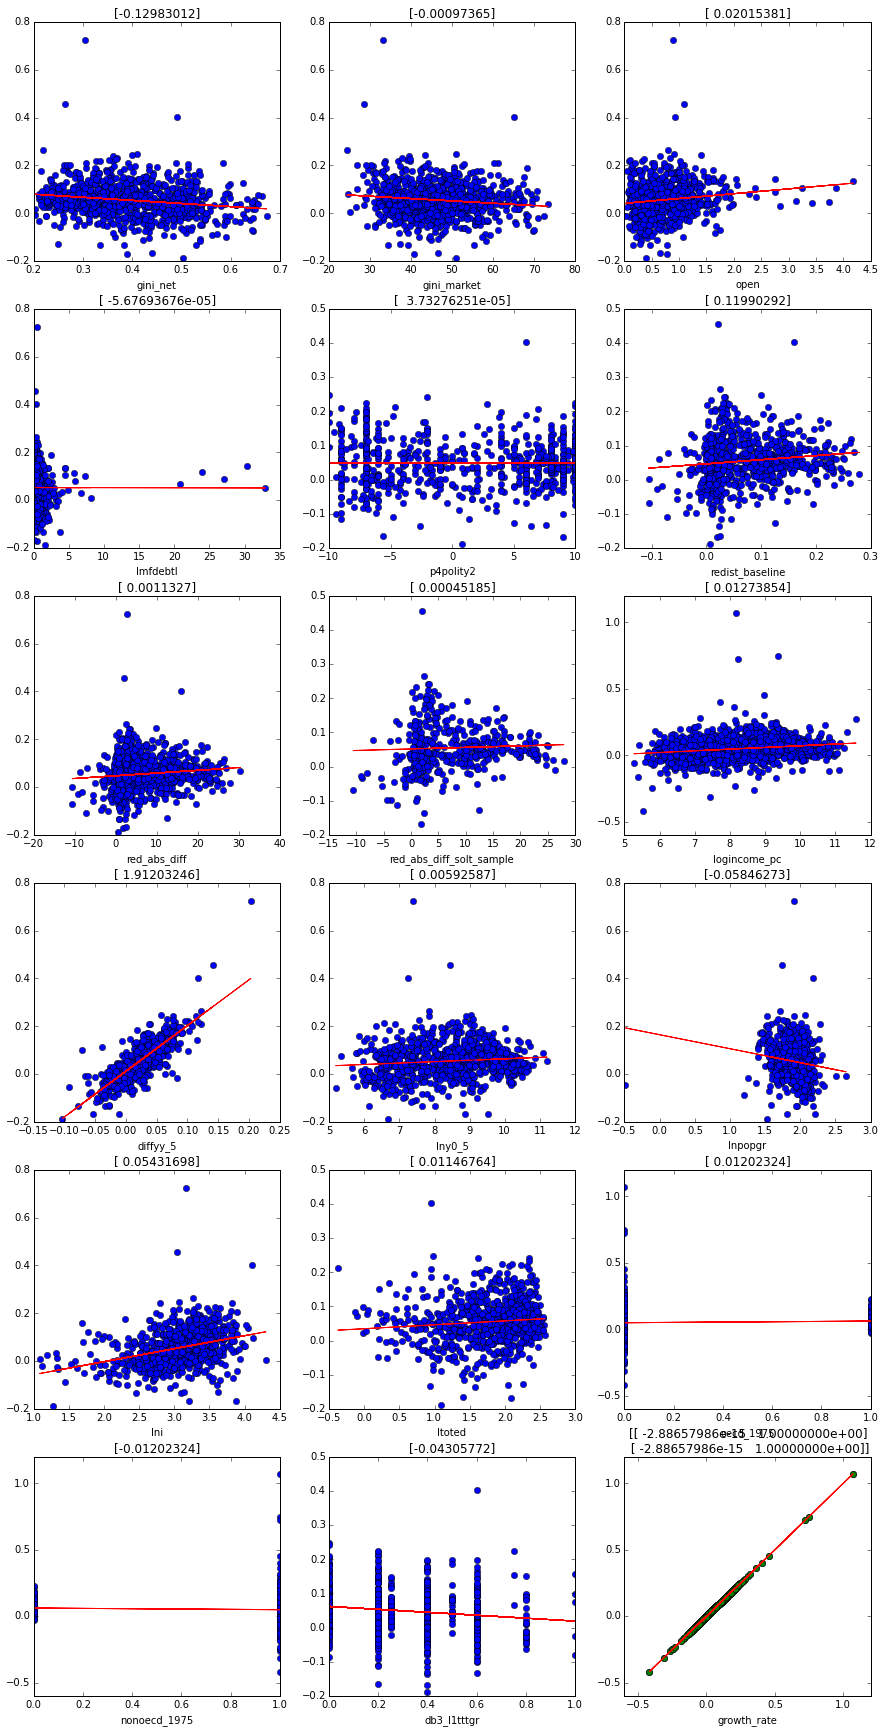

In [123]:
f, axarr = plt.subplots(6, 3, figsize=(15, 30))
for n, var in enumerate(fy_data.keys()):
    i,j = n/3, n%3
    sel = fy_data[[var, 'growth_rate']].dropna(how='any')
    clf = linear_model.LinearRegression()
    clf.fit(sel[[var]], sel['growth_rate'])
    axarr[i, j].plot(sel[var], sel['growth_rate'], 'o')
    axarr[i, j].plot(sel[var], clf.predict(sel[[var]]), 'r')
    axarr[i, j].set_title(clf.coef_)
    axarr[i, j].set_xlabel(var)

# Table 2

## Regular linear regression

In [64]:
sel = fy_data[['gini_market', 'redist_baseline', 'logincome_pc']].dropna()
clf = linear_model.LinearRegression()
clf.fit(sel[['gini_market', 'logincome_pc']], sel['redist_baseline'])
print clf.coef_
print clf.intercept_
print clf.score(sel[['gini_market', 'logincome_pc']], sel['redist_baseline'])

[ 0.00236217  0.03156036]
-0.306448015794
0.339286320144


## Regression on differences

In [65]:
sel['gini_market'] = growth(fy_data, 'gini_market')
sel['redist_baseline'] = growth(fy_data, 'redist_baseline')
sel['logincome_pc'] = growth(fy_data, 'logincome_pc')
sel = sel.dropna()
sel.info()
clf = linear_model.LinearRegression()
clf.fit(sel[['gini_market', 'logincome_pc']], sel['redist_baseline'])
print clf.coef_
print clf.intercept_
print clf.score(sel[['gini_market', 'logincome_pc']], sel['redist_baseline'])

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 679 entries, (USA, 1965.0) to (ROU, 2010.0)
Data columns (total 3 columns):
gini_market        679 non-null float64
redist_baseline    679 non-null float64
logincome_pc       679 non-null float64
dtypes: float64(3)
memory usage: 21.2+ KB
[ 0.00392569  0.00804999]
-0.000384083541234
0.310244198572


## Regression on distance to country mean

In [66]:
means = fy_data.groupby(level=0).mean()
sel = (fy_data[['gini_market', 'redist_baseline', 'logincome_pc']] 
       - means[['gini_market', 'redist_baseline', 'logincome_pc']])
sel['oecd_1975'] = fy_data['oecd_1975']
sel = sel.dropna()

print "Results on whole data :"
clf = linear_model.LinearRegression()
clf.fit(sel[['gini_market', 'logincome_pc']], sel['redist_baseline'])
print clf.coef_
print clf.intercept_
print clf.score(sel[['gini_market', 'logincome_pc']], sel['redist_baseline']), '\n'

print "Results on oecd countries:"
clf = linear_model.LinearRegression()
clf.fit(sel.query("oecd_1975 == 1")[['gini_market', 'logincome_pc']], 
        sel.query("oecd_1975 == 1")['redist_baseline'])
print clf.coef_
print clf.intercept_
print clf.score(sel.query("oecd_1975 == 1")[['gini_market', 'logincome_pc']], 
                sel.query("oecd_1975 == 1")['redist_baseline']), '\n'

print "Results on non-oecd countries:"
clf = linear_model.LinearRegression()
clf.fit(sel.query("oecd_1975 == 0")[['gini_market', 'logincome_pc']], 
        sel.query("oecd_1975 == 0")['redist_baseline'])
print clf.coef_
print clf.intercept_
print clf.score(sel.query("oecd_1975 == 0")[['gini_market', 'logincome_pc']], 
                sel.query("oecd_1975 == 0")['redist_baseline']), '\n'

Results on whole data :
[ 0.0048167  -0.00302689]
-0.00136887698651
0.441811314934 

Results on oecd countries:
[ 0.00566289  0.00685369]
-0.00107527450234
0.612592772558 

Results on non-oecd countries:
[ 0.00461158 -0.00718116]
-0.001561189417
0.417484692624 



# Table 3

## OLS

In [71]:
print "3 variables"
variables = ['gini_net', 'redist_baseline', 'logincome_pc']
sel = fy_data[variables + ['growth_rate']]
sel = sel.dropna()
clf = linear_model.LinearRegression()
clf.fit(sel[variables], sel['growth_rate'])
print pd.DataFrame(index=variables, data=clf.coef_)
print "Constant", clf.intercept_
print "R**2", clf.score(sel[variables], sel['growth_rate']), '\n'


print "5 variables"
variables = ['gini_net', 'redist_baseline', 'logincome_pc', 'lni', 'lnpopgr']
sel = fy_data[variables + ['growth_rate']]
sel = sel.dropna()
clf = linear_model.LinearRegression()
clf.fit(sel[variables], sel['growth_rate'])
print pd.DataFrame(index=variables, data=clf.coef_)
print "Constant", clf.intercept_
print "R**2", clf.score(sel[variables], sel['growth_rate']), '\n'


print "6 variables"
variables = ['gini_net', 'redist_baseline', 'logincome_pc', 'lni', 'lnpopgr', 'ltoted']
sel = fy_data[variables + ['growth_rate']]
sel = sel.dropna()
clf = linear_model.LinearRegression()
clf.fit(sel[variables], sel['growth_rate'])
print pd.DataFrame(index=variables, data=clf.coef_)
print "Constant", clf.intercept_
print "R**2", clf.score(sel[variables], sel['growth_rate']), '\n'

print "all variables"
variables = ['gini_net', 'redist_baseline', 'logincome_pc', 'lni', 'lnpopgr', 'ltoted', 
             'p4polity2', 'open', 'lmfdebtl']
sel = fy_data[variables + ['growth_rate']]
sel = sel.dropna()
clf = linear_model.LinearRegression()
clf.fit(sel[variables], sel['growth_rate'])
print pd.DataFrame(index=variables, data=clf.coef_)
print "Constant", clf.intercept_
print "R**2", clf.score(sel[variables], sel['growth_rate']), '\n'

3 variables
                        0
gini_net        -8.75e-02
redist_baseline -2.69e-03
logincome_pc     6.06e-03
Constant 0.0366438284119
R**2 0.0466503050005 

5 variables
                        0
gini_net        -5.73e-02
redist_baseline  1.65e-02
logincome_pc    -3.73e-03
lni              6.58e-02
lnpopgr         -3.82e-02
Constant -0.0223559986653
R**2 0.182171028324 

6 variables
                        0
gini_net        -5.83e-02
redist_baseline  6.62e-03
logincome_pc    -3.62e-03
lni              6.95e-02
lnpopgr         -3.44e-02
ltoted          -6.58e-03
Constant -0.0282102776758
R**2 0.193473205957 

all variables
                        0
gini_net        -4.99e-02
redist_baseline  3.78e-02
logincome_pc     1.73e-04
lni              6.40e-02
lnpopgr         -1.26e-02
ltoted          -8.67e-03
p4polity2       -3.35e-04
open             1.70e-02
lmfdebtl        -1.32e-02
Constant -0.092751804458
R**2 0.255222485187 



## On distance to country mean

In [72]:
means = fy_data.groupby(level=0).mean()
fy_data_dist = fy_data - means

print "3 variables"
variables = ['gini_net', 'redist_baseline', 'logincome_pc']
sel = fy_data_dist[variables + ['growth_rate']]
sel = sel.dropna()
clf = linear_model.LinearRegression()
clf.fit(sel[variables], sel['growth_rate'])
print pd.DataFrame(index=variables, data=clf.coef_)
print "Constant", clf.intercept_
print "R**2", clf.score(sel[variables], sel['growth_rate']), '\n'

print "5 variables"
variables = ['gini_net', 'redist_baseline', 'logincome_pc', 'lni', 'lnpopgr']
sel = fy_data_dist[variables + ['growth_rate']]
sel = sel.dropna()
clf = linear_model.LinearRegression()
clf.fit(sel[variables], sel['growth_rate'])
print pd.DataFrame(index=variables, data=clf.coef_)
print "Constant", clf.intercept_
print "R**2", clf.score(sel[variables], sel['growth_rate']), '\n'

print "6 variables"
variables = ['gini_net', 'redist_baseline', 'logincome_pc', 'lni', 'lnpopgr', 'ltoted']
sel = fy_data_dist[variables + ['growth_rate']]
sel = sel.dropna()
clf = linear_model.LinearRegression()
clf.fit(sel[variables], sel['growth_rate'])
print pd.DataFrame(index=variables, data=clf.coef_)
print "Constant", clf.intercept_
print "R**2", clf.score(sel[variables], sel['growth_rate']), '\n'

print "all variables"
variables = ['gini_net', 'redist_baseline', 'logincome_pc', 'lni', 'lnpopgr', 'ltoted', 
             'p4polity2', 'open', 'lmfdebtl']
sel = fy_data_dist[variables + ['growth_rate']]
sel = sel.dropna()
clf = linear_model.LinearRegression()
clf.fit(sel[variables], sel['growth_rate'])
print pd.DataFrame(index=variables, data=clf.coef_)
print "Constant", clf.intercept_
print "R**2", clf.score(sel[variables], sel['growth_rate']), '\n'

3 variables
                        0
gini_net         9.08e-02
redist_baseline  2.19e-01
logincome_pc    -4.84e-03
Constant -0.00250184627867
R**2 0.0269292025073 

5 variables
                        0
gini_net         9.54e-02
redist_baseline  1.59e-01
logincome_pc    -9.86e-03
lni              7.07e-02
lnpopgr          1.65e-02
Constant -0.00264233120954
R**2 0.111549828739 

6 variables
                        0
gini_net         7.18e-02
redist_baseline  6.77e-02
logincome_pc     7.57e-04
lni              8.21e-02
lnpopgr          3.88e-03
ltoted          -3.45e-02
Constant -0.00212611179698
R**2 0.152336386609 

all variables
                        0
gini_net         1.02e-01
redist_baseline  6.28e-02
logincome_pc    -2.65e-04
lni              8.15e-02
lnpopgr          6.76e-03
ltoted          -2.79e-02
p4polity2        5.10e-05
open             2.16e-02
lmfdebtl        -1.43e-02
Constant -0.00331331670044
R**2 0.187939146177 



In [55]:
data['roll_growth'] = rolling_mean(data, 'growth', 10, 5, how='futur', sum=True)
data = data.dropna(how='any')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [56]:
#data = resample(data, 5)

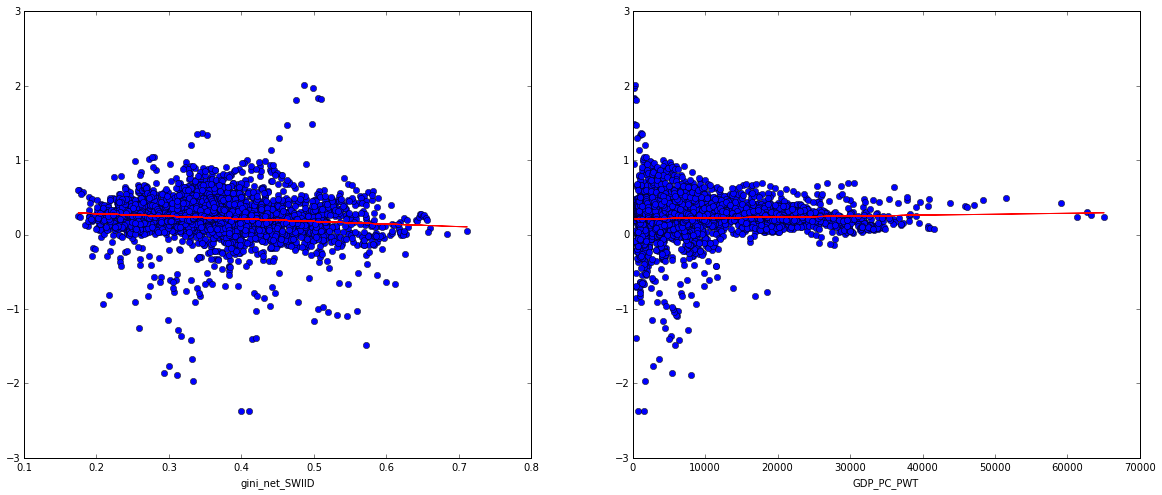

In [57]:
f, axarr = plt.subplots(1, 2, figsize=(20,8))
for n, var in enumerate(variables):
    clf = linear_model.LinearRegression()
    clf.fit(data[[var]], data["roll_growth"])
    axarr[n].plot(data[var], data['roll_growth'], 'o')
    axarr[n].plot(data[var], clf.predict(data[[var]]), 'r')
    axarr[n].set_xlabel(var)
    #axarr[i].set_ylabel('lagged_growth')
    # axarr[i, j].set_title(var)

In [76]:
off_data = pd.read_stata("sdn1402/SDN_spells_dataset.dta")
off_data.set_index(["WBcode", "year"],  inplace=True)
sel = off_data[["gini_net", "gini_market", "redist_baseline"]].dropna()
sel.index.names = ['code', 'year']
sel['growth'] = data['growth']
sel['gini_SWIID'] = data['gini_net_SWIID']

In [77]:
off_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11529 entries, (USA, 1950.0) to (ROU, 2010.0)
Data columns (total 28 columns):
country                             11529 non-null object
ifs                                 11529 non-null float64
gini_net                            4464 non-null float64
gini_market                         4396 non-null float64
red_abs_diff                        4396 non-null float32
red_abs_diff_solt_sample            2158 non-null float32
redist_baseline                     3667 non-null float32
lmfdebtl                            6195 non-null float32
p4polity2                           7187 non-null float64
du3_l1usrategr                      9180 non-null float32
db3_l1tttgr                         6241 non-null float32
acc_stop_10                         11529 non-null float32
length_10                           5064 non-null float32
type_10                             5064 non-null float32
income_pc_10_0                      1898 non-null float32

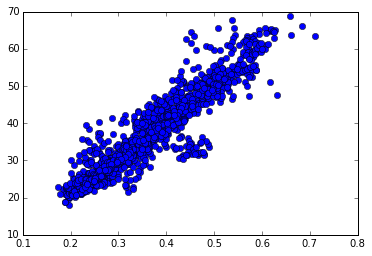

In [79]:
plt.plot(sel['gini_SWIID'], sel['gini_net'], 'o')

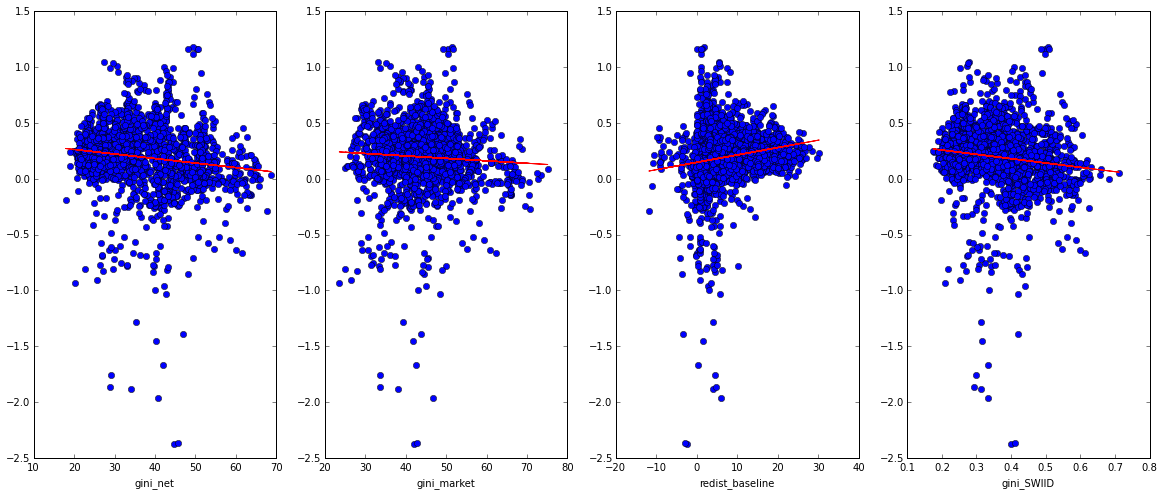

In [78]:
sel['roll_growth'] = rolling_mean(sel, 'growth', 10, 5, how='futur', sum=True)
sel = sel.dropna(how='any')
f, axarr = plt.subplots(1, 4, figsize=(20,8))
for n, var in enumerate(["gini_net", "gini_market", "redist_baseline", "gini_SWIID"]):
    clf = linear_model.LinearRegression()
    clf.fit(sel[[var]], sel["roll_growth"])
    axarr[n].plot(sel[var], sel['roll_growth'], 'o')
    axarr[n].plot(sel[var], clf.predict(sel[[var]]), 'r')
    axarr[n].set_xlabel(var)
    # axarr[i].set_ylabel('lagged_growth')
    # axarr[i, j].set_title(var)

# Market gini vs net gini

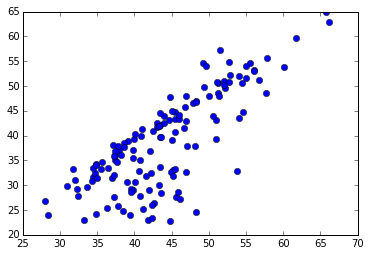

In [26]:
plt.plot(sel['gini_market'].groupby(level=0).mean(), sel['gini_net'].groupby(level=0).mean(), 'o')

In [45]:
data.reset_index(inplace=True)
period = float(5)
tuples = zip(data['code'],
             (((data['year'].values - 1) // period) * period))
df_copy = data.copy()
df_copy.index = pd.MultiIndex.from_tuples(tuples)
df_copy = df_copy.groupby(level=[0, 1]).last().dropna(how='all')
df_copy.index.names = ['code', 'year']

In [64]:
sel = data.query("code == 'FRA'")
sel.loc[((sel.shift(-1).year - sel.year) <= 5) | ((sel.year - sel.shift(1).year) <= 5)]
print pd.concat([sel,(sel.year - 1975 <= 10) * (sel.year - 1975 >= 0)], axis=1)

    code  year  GDP_growth_WB  gini_WIID   year
581  FRA  1970           5.73       0.38  False
582  FRA  1975          -0.98       0.33   True
583  FRA  1979           3.56       0.31   True
584  FRA  1981           1.08       0.32   True
585  FRA  1984           1.52       0.29   True
586  FRA  1989           4.35       0.33  False
587  FRA  1990           2.91       0.28  False
588  FRA  1994           2.35       0.32  False
589  FRA  1995           2.09       0.29  False
590  FRA  1996           1.39       0.28  False
591  FRA  1997           2.34       0.28  False
592  FRA  1998           3.56       0.28  False
593  FRA  1999           3.41       0.28  False
594  FRA  2000           3.88       0.28  False
595  FRA  2001           1.95       0.28  False
596  FRA  2002           1.12       0.27  False
597  FRA  2003           0.82       0.27  False
598  FRA  2004           2.79       0.28  False
599  FRA  2005           1.61       0.28  False
600  FRA  2006           2.37       0.28

In [88]:
period = 10
variable = "GDP_growth_WB"
new_frame = pd.DataFrame()
for country in set(data.index.levels[0]):
    if len(data.query("code == '" + str(country) + "'")) > 1:
        sel = data.query("code == '" + str(country) + "'")
        sel.reset_index(inplace=True)
        sel.set_index(['code', 'year'], inplace=True)
        for yr in sel.index.levels[1]:
            sel[yr] = (sel.index.levels[1] - yr <= period) * (sel.index.levels[1] - yr >= 0)
        sel['mean_growth'] = float('nan')
        for yr in sel.index.levels[1]:
            if sel[yr].sum() > 0:
                growth_mean = (sel[variable] * sel[yr]).mean()
                sel.loc[yr, 'mean_growth'] = growth_mean
        new_frame = pd.concat([new_frame, sel[variables + ['mean_growth']]])
new_frame.info()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3124 entries, (DZA, 1988.0) to (1978, )
Data columns (total 3 columns):
gini_WIID        1562 non-null float64
GDP_growth_WB    1562 non-null float64
mean_growth      1562 non-null float64
dtypes: float64(3)
memory usage: 97.6+ KB


/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:1063: FutureWarning: scalar indexers for index type MultiIndex should be integers and not floating point
  obj = self._convert_scalar_indexer(obj, axis)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [90]:
sel

GDP_growth_WB  gini_WIID 1973.0 1978.0  mean_growth
code year                                                       
CUB  1973.0           3.43       0.28   True  False          NaN
     1978.0           6.60       0.27   True   True          NaN
1973                   NaN        NaN    NaN    NaN         5.02
1978                   NaN        NaN    NaN    NaN         3.30

In [29]:
data.reset_index(inplace=True)
data.sort_values(['code', 'year'], inplace=True)
data.set_index(['code'], inplace=True)

In [38]:
new_frame = pd.DataFrame()
for country in set(data.index.values):
    sel = data.loc[country]
    if len(sel) > 5:
        sel['mean_growth'] = pd.rolling_sum(sel['GDP_growth_WB'], window=6, center=True)
        # sel['gini_growth'] = (sel['gini'] - sel.shift(1)['gini']) / (sel.shift(-1)['year'] - sel['year'])
        new_frame = pd.concat([new_frame, sel])

In [40]:
print new_frame

      year  GDP_growth_WB  gini_WIID  mean_growth
code                                             
EGY   1975           8.94       0.36          NaN
EGY   1981           3.76       0.35          NaN
EGY   1991           1.08       0.32          NaN
EGY   1995           4.64       0.29        28.90
EGY   1996           4.99       0.34        25.33
EGY   1997           5.49       0.37        25.66
EGY   2000           5.37       0.38        31.73
EGY   2004           4.09       0.34        32.23
EGY   2008           7.15       0.29          NaN
EGY   2010           5.14       0.30          NaN
BGD   1973           3.33       0.39          NaN
BGD   1981           7.23       0.37          NaN
BGD   1983           3.88       0.26          NaN
BGD   1986           4.17       0.29        26.47
BGD   1988           2.42       0.28        27.67
BGD   1992           5.44       0.28        25.73
BGD   1996           4.52       0.35        28.38
BGD   2000           5.29       0.32          NaN


In [27]:
print pd.concat([pd.rolling_sum(data['GDP_growth_WB'], window=6), data['GDP_growth_WB']], axis=1)

           GDP_growth_WB  GDP_growth_WB
code year                              
AFG  2007            NaN          13.74
ALB  1996            NaN           9.10
     2002            NaN           4.23
     2004            NaN           5.71
ARG  1961            NaN           5.43
     1963          32.90          -5.31
     1965          29.73          10.57
     1970          23.68           3.05
     1972          21.07           1.63
     1974          20.90           5.53
     1975          15.44          -0.03
     1976          18.73          -2.02
     1977          15.10           6.93
     1978           7.54          -4.51
     1979          16.14          10.22
     1980          14.76           4.15
     1981           9.09          -5.69
     1982           6.16          -4.96
     1983           3.10           3.88
     1985           0.02          -7.59
     1986          -2.33           7.88
     1987          -3.57           2.91
     1988          -0.44          -2.56


## Adding one dummy per country + one per period

In [187]:
for country in sorted(np.unique(data.index.levels[0])):
    data.loc[:, country] = (data.reset_index()['code'] == country).astype(int).values
for period in sorted(np.unique(data.index.levels[1])):
    data.loc[:, period] = (data.reset_index()['year'] == period).astype(int).values

## Normalize the data

In [188]:
data = (data - data.mean(axis=0)) / data.std(axis=0)

## Define the variables

In [189]:
variables = data.keys().tolist()[:4] + ['log(GNI_PC)']
dummies = sorted(np.unique(data.index.levels[0])) + sorted(np.unique(data.index.levels[1]))

## Select the variables

In [190]:
X = data[variables + dummies]
X_dum = data[dummies]
X_var = data[variables]
Y = data['growth']

## Linear regression

Original variance of the sample :  1.0
Variance of the residu : 0.275955379638
Explained variance share :  0.724044620362
Gini coefficient :  0.640766934057
estimation of the gini importance :  5.20588798726e-15


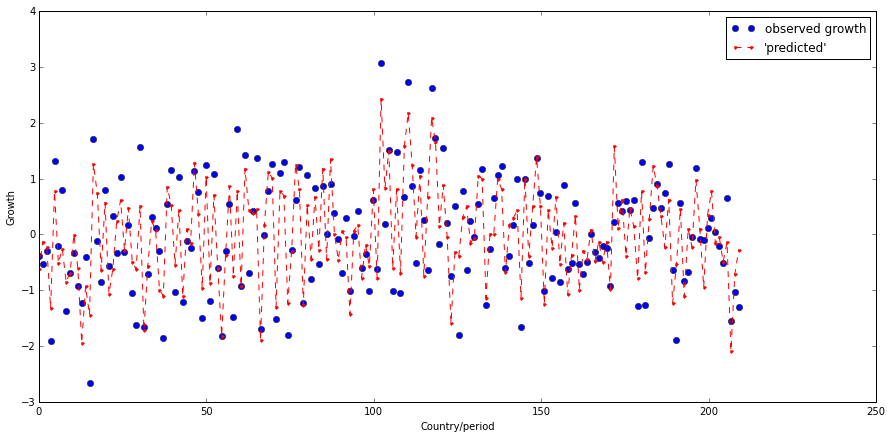

In [191]:
clf = linear_model.LinearRegression()
clf.fit(X, Y)

x = np.linspace(0, 209, len(data))
plt.figure(figsize=(15,7))
plt.plot(x, Y, 'o', label="observed growth")
plt.plot(x, clf.predict(X), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

print "Original variance of the sample : ", Y.var()
print "Variance of the residu :", (Y - clf.predict(X)).var()
print "Explained variance share : ", (Y.var() - (Y - clf.predict(X)).var()) / Y.var()
print "Gini coefficient : ",  pd.DataFrame(index=X.keys(), data=clf.coef_).loc['gini'].values[0]
print "estimation of the gini importance : ", clf.coef_[0] / np.absolute(clf.coef_).sum()

## Same linear regression in two steps

Growth variance :  1.0
Variance of the residu : 0.447612055284
Explained variance share :  0.552387944716


Variance of the residu :  0.447612055284
Variance of the new residu (of the regression on the residu) : 0.422514621772
Explained variance share :  0.0250974335114
Gini coefficient :  0.0381527477191
estimation of the gini importance :  0.00349915407608


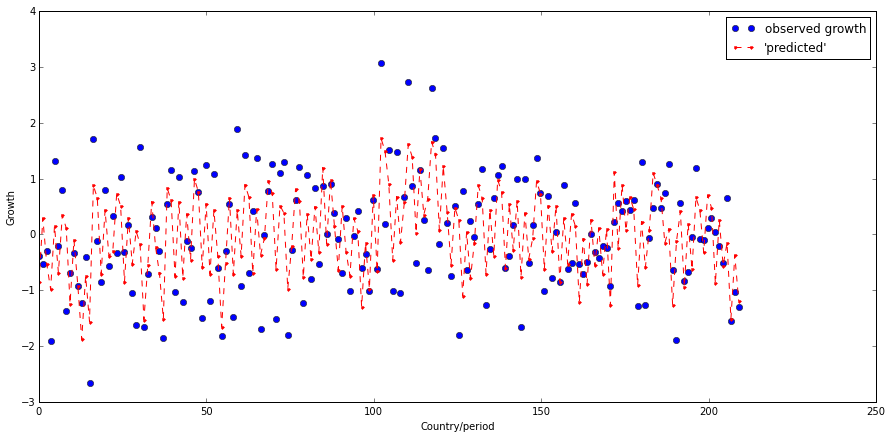

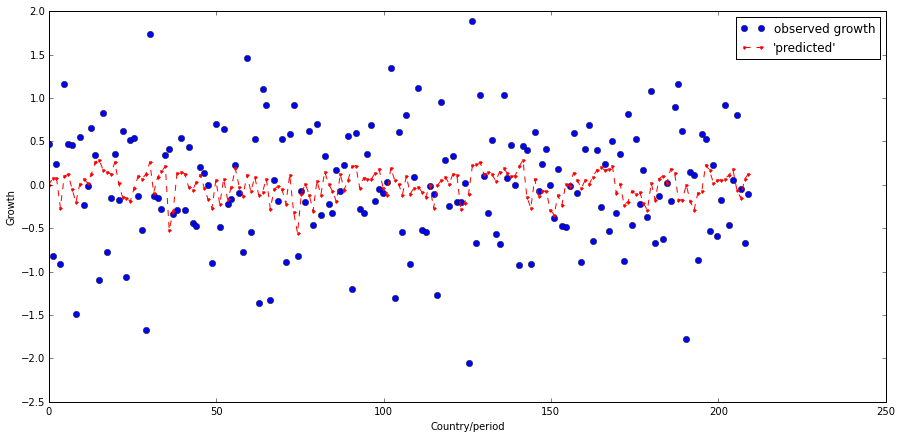

In [192]:
# Only with dummy variables
clf_dum = linear_model.LinearRegression()
clf_dum.fit (X_dum, Y)

x = np.linspace(0, 209, len(data))
plt.figure(figsize=(15,7))
plt.plot(x, Y, 'o', label="observed growth")
plt.plot(x, clf_dum.predict(X_dum), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

print "Growth variance : ", Y.var()
print "Variance of the residu :", (Y - clf_dum.predict(X_dum)).var()
print "Explained variance share : ", (Y.var() - (Y - clf_dum.predict(X_dum)).var()) / Y.var()
print '\n'

# Only with non dummy variables
clf_var = linear_model.LinearRegression()
Y_res = Y - clf_dum.predict(X_dum)
clf_var.fit (X_var, Y_res)

x = np.linspace(0, 209, len(data))
plt.figure(figsize=(15,7))
plt.plot(x, Y_res, 'o', label="observed growth")
plt.plot(x, clf_var.predict(X_var), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

print "Variance of the residu : ", Y_res.var()
print "Variance of the new residu (of the regression on the residu) :", (Y_res - clf_var.predict(X_var)).var()
print "Explained variance share : ", (Y_res.var() - (Y_res - clf_var.predict(X_var)).var()) / Y.var()
print "Gini coefficient : ",  pd.DataFrame(index=X_var.keys(), data=clf_var.coef_).loc['gini'].values[0]
print "estimation of the gini importance : ", (clf_var.coef_[0] / np.absolute(clf_var.coef_).sum() * 
                                               (Y_res.var() - (Y_res - clf_var.predict(X_var)).var()) / Y.var())

## Same thing the other way around

Growth variance :  1.0
Variance of the residu : 0.910199259716
Explained variance share :  0.0898007402836
Gini coefficient :  0.0622980615046
estimation of the gini importance :  0.0454854795169


Variance of the residu :  0.910199259716
Variance of the new residu (of the regression on the residu) : 0.383583963339
Explained variance share :  0.526615296377


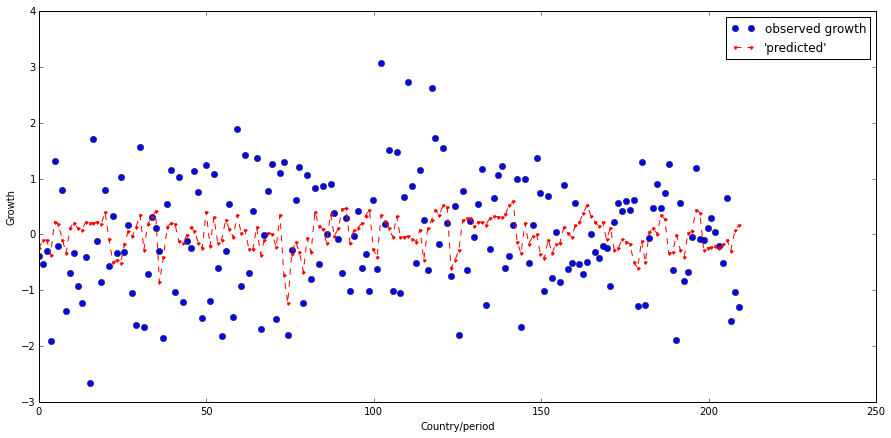

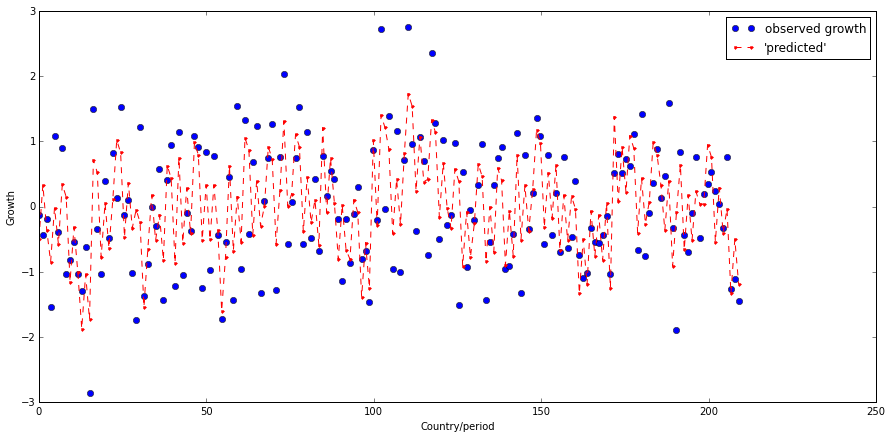

In [193]:
# Only with non-dummy variables
clf_var = linear_model.LinearRegression()
clf_var.fit (X_var, Y)

x = np.linspace(0, 209, len(data))
plt.figure(figsize=(15,7))
plt.plot(x, Y, 'o', label="observed growth")
plt.plot(x, clf_var.predict(X_var), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

print "Growth variance : ", Y.var()
print "Variance of the residu :", (Y - clf_var.predict(X_var)).var()
print "Explained variance share : ", (Y.var() - (Y - clf_var.predict(X_var)).var()) / Y.var()
print "Gini coefficient : ",  pd.DataFrame(index=X_var.keys(), data=clf_var.coef_).loc['gini'].values[0]
print "estimation of the gini importance : ", np.absolute(clf_var.coef_[0]) / np.absolute(clf_var.coef_).sum()
print '\n'
                                               
# Only with dummy variables
clf_dum = linear_model.LinearRegression()
Y_res = Y - clf_var.predict(X_var)
clf_dum.fit(X_dum, Y_res)

x = np.linspace(0, 209, len(data))
plt.figure(figsize=(15,7))
plt.plot(x, Y_res, 'o', label="observed growth")
plt.plot(x, clf_dum.predict(X_dum), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

print "Variance of the residu : ", Y_res.var()
print "Variance of the new residu (of the regression on the residu) :", (Y_res - clf_dum.predict(X_dum)).var()
print "Explained variance share : ", (Y_res.var() - (Y_res - clf_dum.predict(X_dum)).var()) / Y.var()

## Trying to explain all this

In [194]:
data['stand_growth'] = Y - Y.groupby(level=0).mean()

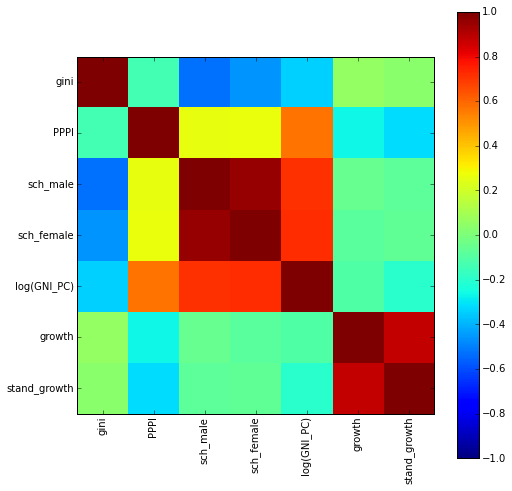

In [195]:
plot_correlations(data[variables + ['growth', "stand_growth"]], size_tuple=(8,8))

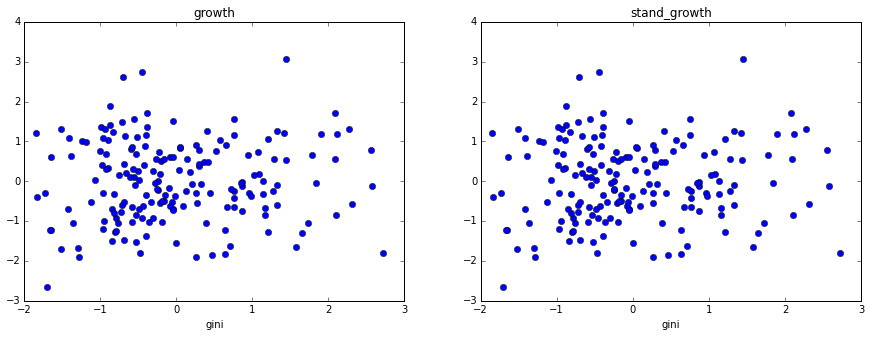

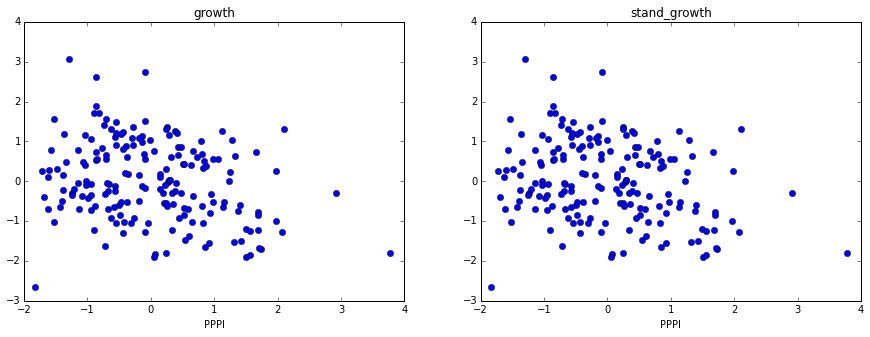

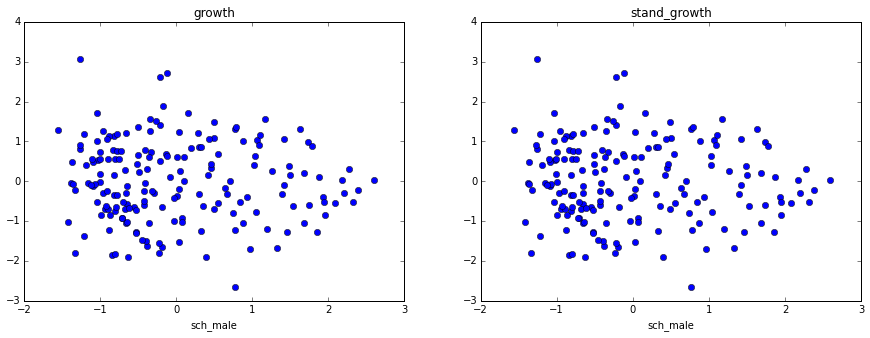

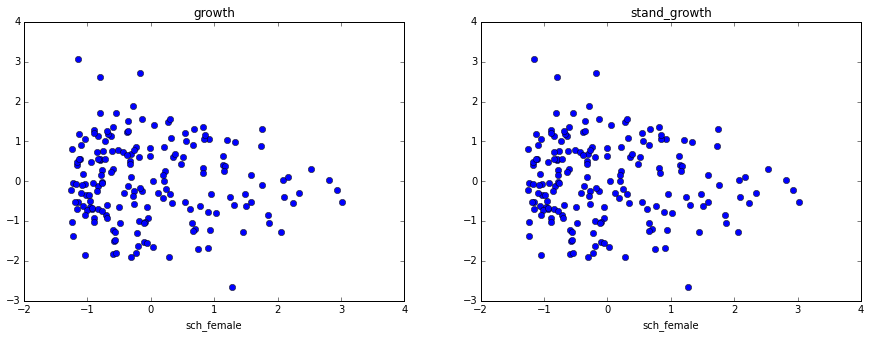

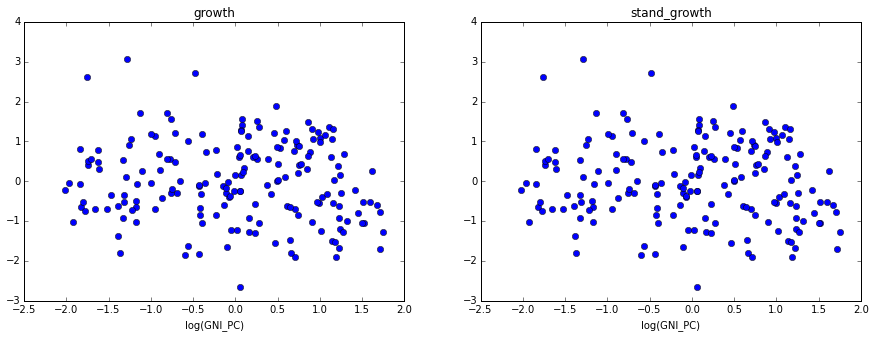

In [196]:
for var in variables:
    f, axarr = plt.subplots(1, 2, figsize=(15, 5))
    axarr[0].set_xlabel(var)    
    axarr[0].plot(data[var], Y, 'o')
    axarr[0].set_title('growth')
    axarr[1].set_xlabel(var)    
    axarr[1].plot(data[var], Y, 'o')
    axarr[1].set_title('stand_growth')

In [197]:
for var in variables + ['growth']:
    print "Mean standard deviation of the " + var + " within a country : ", data[var].groupby(level=0).std().mean()
    print "Expected value", np.mean([np.random.choice(data[var], k).std() 
                                     for k in data[var].groupby(level=0).size().tolist() * 200])
    print '\n'

Mean standard deviation of the gini within a country :  0.267671454774
Expected value 0.748279339459


Mean standard deviation of the PPPI within a country :  0.606095807069
Expected value 0.750282684126


Mean standard deviation of the sch_male within a country :  0.30290727019
Expected value 0.746459476871


Mean standard deviation of the sch_female within a country :  0.274122643011
Expected value 0.735430540698


Mean standard deviation of the log(GNI_PC) within a country :  0.388727011499
Expected value 0.762236511666


Mean standard deviation of the growth within a country :  0.970336973784
Expected value 0.75475941055




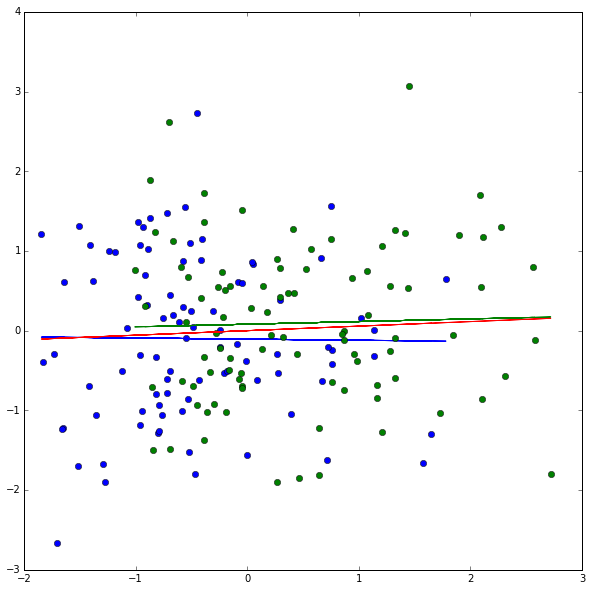

In [198]:
high_school = data[data['sch_female'] > data['sch_female'].median()]
low_school = data[data['sch_female'] <= data['sch_female'].median()]
plt.figure(figsize=(10, 10))

model = linear_model.LinearRegression()
model.fit(data['gini'].reshape((len(data),1)), data['growth'].reshape((len(data),1)))

low_model = linear_model.LinearRegression()
low_model.fit(low_school['gini'].reshape((len(low_school),1)), low_school['growth'].reshape((len(low_school),1)))

high_model = linear_model.LinearRegression()
high_model.fit(high_school['gini'].reshape((len(high_school),1)), high_school['growth'].reshape((len(high_school),1)))

plt.plot(high_school['gini'], high_school['growth'], 'bo')
plt.plot(high_school['gini'], high_model.predict(high_school['gini'].reshape((len(high_school),1))), 'b-')

plt.plot(low_school['gini'], low_school['growth'], 'go')
plt.plot(low_school['gini'], low_model.predict(low_school['gini'].reshape((len(low_school),1))), 'g-')

plt.plot(data['gini'], model.predict(data['gini'].reshape((len(data),1))), 'r-')

# Cross validating the coefficient to ensure no overfitting

Best alpha parameter :  {'alpha': 0.095409547634999439}
Best score :  0.182836662632
Original variance of the sample :  1.0
Variance of the residu : 0.594486108977
Explained variance share :  0.405513891023


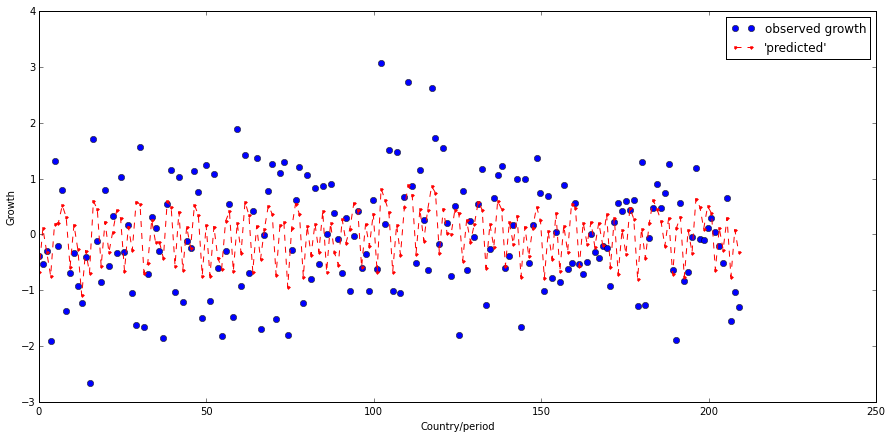

In [199]:
parameters = {'alpha':np.logspace(-5, 0, 50)}
lm = linear_model.Lasso()
clf = grid_search.RandomizedSearchCV(lm, parameters, cv=18)
clf.fit(X, Y)
print "Best alpha parameter : ", clf.best_params_
print "Best score : ", clf.best_score_

x = np.linspace(0, 209, len(Y))
plt.figure(figsize=(15,7))
plt.plot(x, Y, 'o', label="observed growth")
plt.plot(x, clf.predict(X), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

print "Original variance of the sample : ", Y.var()
print "Variance of the residu :", (Y - clf.predict(X)).var()
print "Explained variance share : ", (Y.var() - (Y - clf.predict(X)).var()) / Y.var()

In [200]:
coefs = pd.DataFrame(index=X.keys(), data=clf.best_estimator_.coef_)
print coefs[coefs[0]!=0]

             0
PPPI -8.96e-02
BGD  -6.61e-03
BGR  -7.22e-02
HKG   7.27e-03
IND  -1.02e-02
IRN   1.98e-02
JPN   6.33e-02
KOR   4.83e-02
VEN  -9.83e-03
1965  1.29e-01
1970  1.10e-01
1975 -3.02e-01
1985 -1.62e-01


Faire un lasso en autorisant uniquement une pénalisation sur les dummies pays (en ajoutant éventuellement les pays les plus particuliers)

# Try to cross validate the sign of the gini coefficient

In [201]:
coefs = pd.DataFrame(index=X.keys())
kf = cross_validation.KFold(len(X), n_folds=4, shuffle=True)
for i, (train_index, test_index) in enumerate(kf):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.values[train_index], X.values[test_index]
    Y_train, Y_test = Y.values[train_index], Y.values[test_index]
    clf = linear_model.LinearRegression()
    clf.fit(X_train, Y_train)
    print i, "th fold"
    print "Original variance of the sample : ", Y_test.var()
    print "Variance of the residu :", (Y_test - clf.predict(X_test)).var()
    print "Explained variance share : ", (Y_test.var() - (Y_test - clf.predict(X_test)).var()) / Y_test.var(), '\n'
    coefs[i] = clf.coef_
coefs['std'] = coefs.std(axis=1)
coefs['mean'] = coefs.mean(axis=1)
print coefs

0 th fold
Original variance of the sample :  0.740272551968
Variance of the residu : 1.83852949724e+24
Explained variance share :  -2.48358458294e+24 

1 th fold
Original variance of the sample :  1.19260280359
Variance of the residu : 1.0162267462e+26
Explained variance share :  -8.52108298876e+25 

2 th fold
Original variance of the sample :  1.06950147513
Variance of the residu : 5.82002027267e+25
Explained variance share :  -5.44180668097e+25 

3 th fold
Original variance of the sample :  0.931840193284
Variance of the residu : 3.51150702e+27
Explained variance share :  -3.76835754167e+27 

                    0         1         2         3       std      mean
gini         6.26e-01  9.61e-01  4.28e-01  5.69e-01  2.26e-01  5.62e-01
PPPI        -4.17e-01 -6.24e-01 -4.06e-01 -7.65e-01  1.73e-01 -4.08e-01
sch_male     3.41e-01  2.30e+00  7.80e-01  6.61e-01  8.72e-01  9.90e-01
sch_female   5.09e-01 -7.68e-01  3.35e-01  6.88e-01  6.55e-01  2.84e-01
log(GNI_PC) -1.49e+00 -1.21e+00 -1.24e

# Comparing the Lasso with the OLS

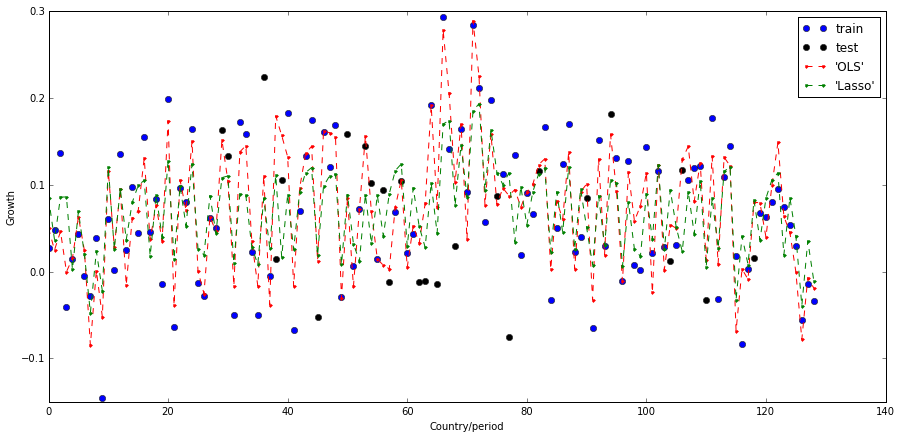

In [248]:
n_folds = 5

# Finding the best alpha
parameters = {'alpha':np.logspace(-5, 0, 50)}
lm = linear_model.Lasso()
clf_lasso = grid_search.RandomizedSearchCV(lm, parameters, cv=n_folds)
clf_lasso.fit(X, Y)
best_alpha = clf_lasso.best_params_


clf = linear_model.LinearRegression()
clf.fit(X, Y)

R_dict = {'lasso': [], 'OLS': [], 'gini_lasso': []}
for k in range(50):
    kf = cross_validation.KFold(len(X), n_folds=n_folds, shuffle=True)
    for i, (train_index, test_index) in enumerate(kf):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        clf = linear_model.Lasso(alpha=10**-12)
        clf.fit(X_train, Y_train)
        clf_l = linear_model.Lasso(alpha=best_alpha['alpha'])
        clf_l.fit(X_train, Y_train)
        #print i, "th fold"
        OLS_res = (Y_test.var() - (Y_test - clf.predict(X_test)).var()) / Y_test.var()
        #print "R^2 OLS", OLS_res
        lasso_res = (Y_test.var() - (Y_test - clf_l.predict(X_test)).var()) / Y_test.var()
        #print "R^2 Lasso", lasso_res
        R_dict['lasso'].append(lasso_res)
        R_dict['OLS'].append(OLS_res)
        R_dict['gini_lasso'].append(clf_l.coef_[0])
        #print '\n'


x = range(len(data))
plt.figure(figsize=(15,7))
plt.plot(train_index, Y_train, 'bo', label="train")
plt.plot(test_index, Y_test, 'ko', label="test")
plt.plot(x, clf.predict(X), 'r--.', label="'OLS'")
plt.plot(x, clf_l.predict(X), 'g--.', label="'Lasso'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

In [249]:
print np.mean(R_dict['lasso']), np.std(R_dict['lasso'])
print np.mean(R_dict['OLS']), np.std(R_dict['OLS'])
print np.mean(R_dict['gini_lasso']), np.std(R_dict['gini_lasso'])

0.319901135446 0.130068716376
0.226001417938 0.399369902545
-5.848941954e-07 9.22947472683e-06


In [250]:
print pd.DataFrame(index=X.columns, data=clf_l.coef_)[clf_l.coef_ != 0]

               0
BGD    -4.79e-03
BGR    -1.16e-02
ESP    -1.39e-03
FRA     1.43e-03
IDN    -1.44e-03
ITA     1.70e-03
JPN     1.21e-02
KOR     1.38e-02
SGP     1.49e-03
TTO    -5.61e-03
VEN    -8.11e-03
1965.0  6.25e-03
1970.0  1.06e-02
1975.0 -2.74e-02
1985.0 -1.96e-02
PPPI   -7.69e-03


# Comparing with and without Gini

In [252]:
n_folds = 5


R_dict = {'without_gini': [], 'with_gini': []}
for k in range(50):
    kf = cross_validation.KFold(len(X), n_folds=n_folds, shuffle=True)
    for i, (train_index, test_index) in enumerate(kf):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        clf = linear_model.Lasso(alpha=10**-12)
        clf.fit(X_train, Y_train)
        clf_wg = linear_model.Lasso(alpha=10**-12)
        clf_wg.fit(X_train[:, 1:], Y_train)
        #print i, "th fold"
        OLS = (Y_test.var() - (Y_test - clf.predict(X_test)).var()) / Y_test.var()
        #print "R^2 OLS", OLS_res
        without_gini = (Y_test.var() - (Y_test - clf_wg.predict(X_test[:, 1:])).var()) / Y_test.var()
        #print "R^2 Lasso", lasso_res
        R_dict['without_gini'].append(without_gini)
        R_dict['with_gini'].append(OLS)
        #R_dict['gini_lasso'].append(clf_wg.coef_[0])
        #print '\n'

print "No gini prediction", np.mean(R_dict['without_gini']), np.std(R_dict['without_gini'])
print "Gini prediction", np.mean(R_dict['with_gini']), np.std(R_dict['with_gini'])
        
# x = range(len(data))
#plt.figure(figsize=(15,7))
#plt.plot(train_index, Y_train, 'bo', label="train")
#plt.plot(test_index, Y_test, 'ko', label="test")
# plt.plot(x, clf.predict(X), 'r--.', label="'OLS'")
#plt.plot(x, clf_wg.predict(X[:, 1:]), 'g--.', label="'Lasso'")
#plt.legend()
#plt.ylabel("Growth")
#plt.xlabel("Country/period")

No gini prediction 0.215771445848 0.388843143605
Gini prediction 0.21211028978 0.387564822105


### Changing the relative normalization of the variable to change artificially the effect of Lasso

In [129]:
data = pd.read_csv("forbes_dataset.csv", index_col=['code', 'year'])
print data.info()
print "Number of countries : ", len(data.index.levels[0])
for country in sorted(np.unique(data.index.levels[0])):
    data.loc[:, country] = (data.reset_index()['code'] == country).astype(int).values
for period in sorted(np.unique(data.index.levels[1])):
    data.loc[:, period] = (data.reset_index()['year'] == period).astype(int).values
data = (data - data.mean(axis=0)) / data.std(axis=0)

time_dummies = sorted(np.unique(data.index.levels[1]))
country_dummies = sorted(np.unique(data.index.levels[0]))

X = pd.DataFrame(columns=country_dummies)
X[country_dummies] = data[country_dummies] / 4
X[time_dummies] = data[time_dummies] / 4
X[variables] = data[variables]
Y = data['growth']

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 181 entries, (AUS, 1975.0) to (VEN, 1985.0)
Data columns (total 6 columns):
gini           181 non-null float64
PPPI           181 non-null float64
sch_male       181 non-null float64
sch_female     181 non-null float64
log(GNI_PC)    181 non-null float64
growth         181 non-null float64
dtypes: float64(6)
memory usage: 9.9+ KB
None
Number of countries :  46


Best alpha parameter :  {'alpha': 0.0071968567300115215}
Best score :  0.207669066918
Original variance of the sample :  1.0
Variance of the residu : 0.402366530148
Explained variance share :  0.597633469852


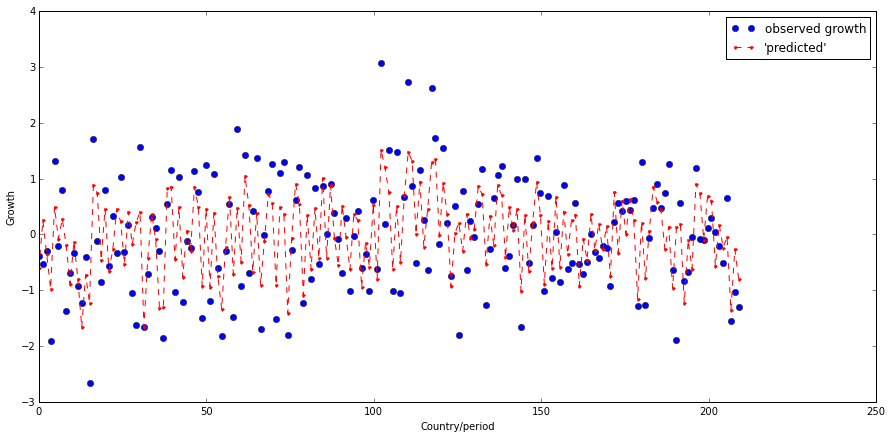

In [130]:
parameters = {'alpha':np.logspace(-5, 0, 50)}
lm = linear_model.Lasso()
clf = grid_search.RandomizedSearchCV(lm, parameters, cv=5)
clf.fit(X, Y)
print "Best alpha parameter : ", clf.best_params_
print "Best score : ", clf.best_score_

x = np.linspace(0, 209, len(Y))
plt.figure(figsize=(15,7))
plt.plot(x, Y, 'o', label="observed growth")
plt.plot(x, clf.predict(X), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

print "Original variance of the sample : ", Y.var()
print "Variance of the residu :", (Y - clf.predict(X)).var()
print "Explained variance share : ", (Y.var() - (Y - clf.predict(X)).var()) / Y.var()

In [131]:
print pd.DataFrame(index=X.columns, data=clf.best_estimator_.coef_)[clf.best_estimator_.coef_ != 0]

                    0
BGD         -2.01e-01
BGR         -7.64e-01
CHL         -3.61e-01
DEU          3.34e-02
DOM         -2.65e-01
FRA          5.44e-03
GAB          2.74e-01
HKG          3.23e-01
IND         -3.24e-01
IRN          2.12e-01
ITA          4.02e-02
JPN          5.65e-01
KOR          3.72e-01
LKA         -4.70e-02
NOR          1.94e-01
PAK         -1.88e-01
PHL         -4.72e-02
PRT         -1.19e-01
SGP          3.83e-01
THA          3.51e-03
TUN          8.91e-02
TUR         -7.59e-02
USA         -1.16e-01
VEN         -2.82e-01
1960.0      -1.08e-02
1965.0       9.07e-01
1970.0       9.07e-01
1975.0      -1.04e+00
1985.0      -8.94e-01
gini         9.28e-04
PPPI        -4.11e-01
sch_male     3.82e-02
log(GNI_PC)  1.74e-01


## Testing for non-linear hypothesis as in Banerjee-Duflo

In [244]:
data = pd.read_csv("forbes_dataset_ineq_growth.csv", index_col=['code', 'year'])
print data.info()
print "Number of countries : ", len(data.index.levels[0])
for country in sorted(np.unique(data.index.levels[0])):
    data.loc[:, country] = (data.reset_index()['code'] == country).astype(int).values
for period in sorted(np.unique(data.index.levels[1])):
    data.loc[:, period] = (data.reset_index()['year'] == period).astype(int).values

time_dummies = sorted(np.unique(data.index.levels[1]))
country_dummies = sorted(np.unique(data.index.levels[0]))

variables = ['PPPI', 'sch_male', 'sch_female', 'log(GNI_PC)', 
             'gini_growth']

X = pd.DataFrame(columns=country_dummies)
X[country_dummies] = data[country_dummies] / 15
X[time_dummies] = data[time_dummies] / 15
X[variables] = data[variables]
X['gini_growth^2'] = X['gini_growth']**2
Y = data['growth']

X = (X - X.mean(axis=0)) / X.std(axis=0)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 129 entries, (AUS, 1980.0) to (VEN, 1985.0)
Data columns (total 7 columns):
gini           129 non-null float64
PPPI           129 non-null float64
sch_male       129 non-null float64
sch_female     129 non-null float64
log(GNI_PC)    129 non-null float64
growth         129 non-null float64
gini_growth    129 non-null float64
dtypes: float64(7)
memory usage: 8.1+ KB
None
Number of countries :  35


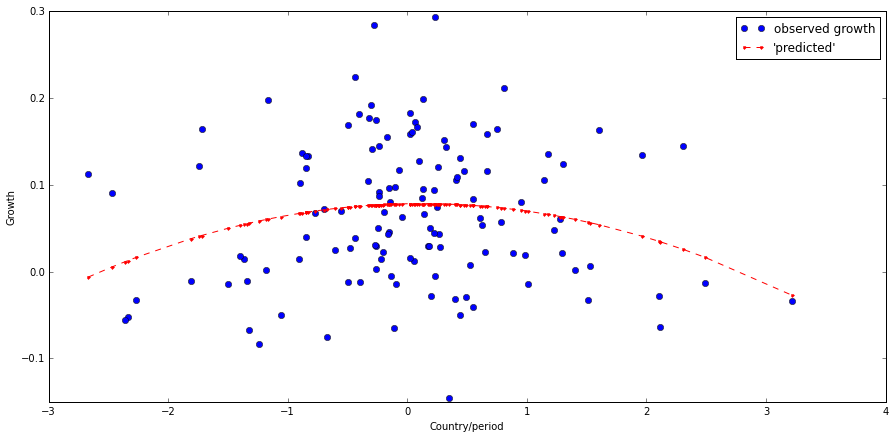

In [245]:
clf = linear_model.LinearRegression()
clf.fit(X[['gini_growth', 'gini_growth^2']], Y)
x = np.linspace(0, 209, len(Y))
plt.figure(figsize=(15,7))
plt.plot(X['gini_growth'], Y, 'o', label="observed growth")
plt.plot(X.sort_values('gini_growth')['gini_growth'], 
         clf.predict(X.sort_values('gini_growth')[['gini_growth', 'gini_growth^2']]), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

Best alpha parameter :  {'alpha': 0.0013894954943731374}
Best score :  -0.0210363672902
Original variance of the sample :  0.00658270459762
Variance of the residu : 0.00211867549017
Explained variance share :  0.678145136434


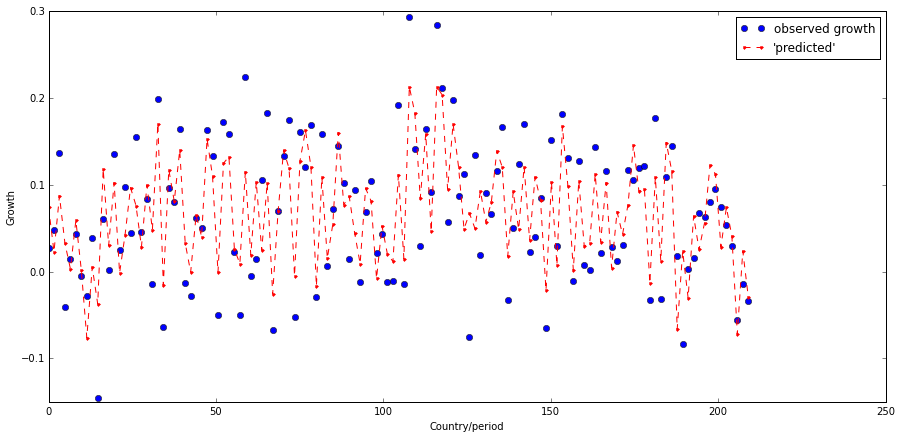

In [246]:
parameters = {'alpha':np.logspace(-5, 0, 50)}
lm = linear_model.Lasso()
clf = grid_search.RandomizedSearchCV(lm, parameters, cv=5)
clf.fit(X, Y)
print "Best alpha parameter : ", clf.best_params_
print "Best score : ", clf.best_score_

x = np.linspace(0, 209, len(Y))
plt.figure(figsize=(15,7))
plt.plot(x, Y, 'o', label="observed growth")
plt.plot(x, clf.predict(X), 'r--.', label="'predicted'")
plt.legend()
plt.ylabel("Growth")
plt.xlabel("Country/period")

print "Original variance of the sample : ", Y.var()
print "Variance of the residu :", (Y - clf.predict(X)).var()
print "Explained variance share : ", (Y.var() - (Y - clf.predict(X)).var()) / Y.var()

In [247]:
print pd.DataFrame(index=X.columns, data=clf.best_estimator_.coef_)[clf.best_estimator_.coef_ != 0]

                      0
AUS           -2.28e-03
BGD           -7.11e-03
BGR           -2.23e-02
CHN           -8.84e-04
DEU            6.45e-03
DNK            4.20e-03
ESP            1.95e-03
FIN            1.61e-03
FRA            5.31e-03
GBR            4.07e-03
HKG            1.03e-02
IDN           -4.31e-03
IND           -1.18e-02
ITA            1.85e-03
JPN            1.65e-02
KOR            1.07e-02
LKA           -6.11e-03
MYS           -7.51e-04
NLD            2.48e-04
NOR            1.16e-02
PAK           -5.43e-03
SGP            1.59e-02
SWE            4.32e-03
TTO           -4.04e-03
TUN            3.87e-03
USA           -5.40e-03
VEN           -7.84e-03
1965.0         1.71e-02
1970.0         1.58e-02
1975.0        -1.80e-02
1985.0        -1.92e-02
PPPI          -3.89e-02
sch_male       1.55e-02
gini_growth^2 -1.71e-03
